<a href="https://colab.research.google.com/github/NigarRahimli/Branches/blob/main/DataMining2024_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Assignment 2



## Image Data Download

You can do it manually as well from the given URL.

In [ ]:
!wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip
!unzip /content/patches_256.zip -d /content/

--2025-03-16 13:31:17--  https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip
Resolving warwick.ac.uk (warwick.ac.uk)... 137.205.28.41
Connecting to warwick.ac.uk (warwick.ac.uk)|137.205.28.41|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 1729436294 (1.6G) [application/zip]
Saving to: ‘patches_256.zip.1’

patches_256.zip.1    24%[===>                ] 403.85M  5.65MB/s    eta 4m 46s 

## Download and load expression data into a dataframe

This data can be read using this code (not to be changed). Each row in the resulting data frame contains information about a single spot such as its spatial location coordinates (Location_Center_Y, Location_Center_X) and the expression values of 38 different proteins. The names of the proteins are given in the list “proteins_names”.  The code  also creates two additional columns 'specimen_id' and 'image_id' which will be needed for this assignment. df.specimen_id contains the identifier or name of the specimen (A1, B1, C1 or D1) from which the spot originates.  df.image_id contains the file name of the image file corresponding to each spot (without the png extension).

Note there may be some images for which no expression is available. You can drop those images.


In [ ]:
import pandas as pd
df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')


df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(df)


# Showing an example image

The code below will load an example image. It also shows how you can get the HED channels.

skimage version 0.25.1


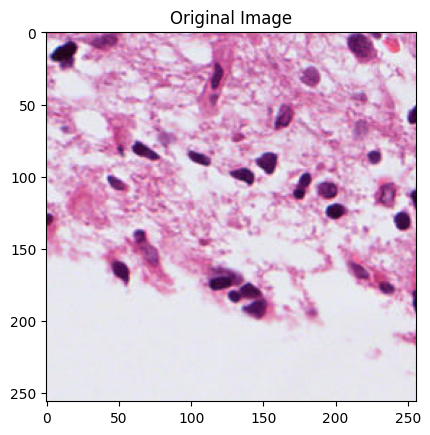

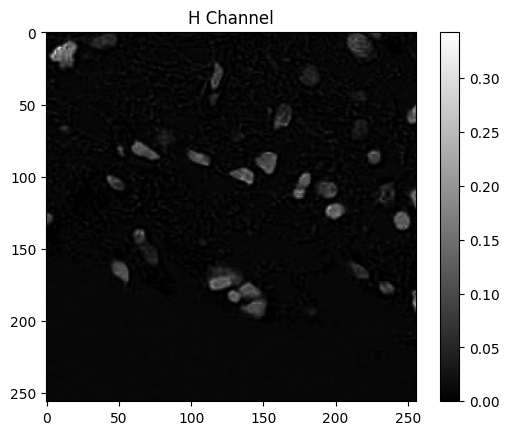

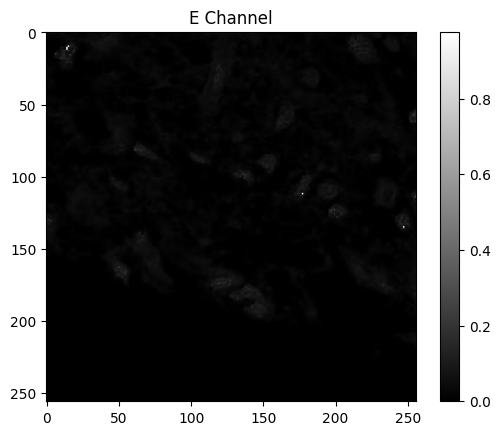

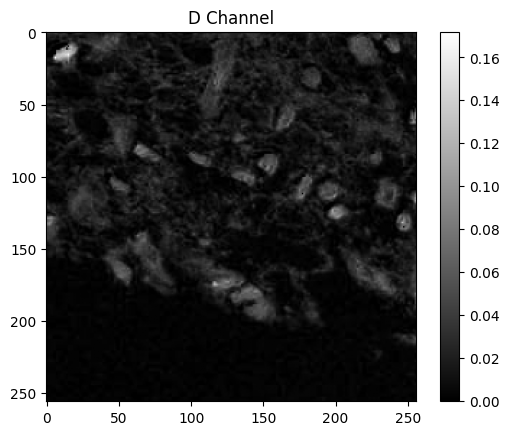

In [ ]:
image_folder = '/content/patches_256/'
from skimage.color import rgb2hed
import skimage
from skimage.io import imread
from skimage.color import rgba2rgb
import matplotlib.pyplot as plt

# Replace 'path_to_image' with the path to the image you want to display
image_path = image_folder+'A1_0x40.png'
print('skimage version',skimage.__version__)
import matplotlib.pyplot as plt
I = rgba2rgb(imread(image_path)) #read sample RGB image
I_hed =  rgb2hed(I) #convert to HED
plt.imshow(I);plt.title('Original Image');plt.show()
I_h = I_hed[:,:,0]; plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('H Channel');plt.show()
I_e = I_hed[:,:,1]; plt.figure();  plt.imshow(I_e,cmap='gray');plt.colorbar();plt.title('E Channel');plt.show()
I_d = I_hed[:,:,2]; plt.figure();  plt.imshow(I_d,cmap='gray');plt.colorbar();plt.title('D Channel');plt.show()


## Useful hints:
* Feel free to resize the images to reduce the amount of required compute. However, if you do this, please ensure that the code for doing this is included in your submission notebook.

* Look at glob (https://docs.python.org/3/library/glob.html) to get list of all file names in a given folder.

* For calculating various regression metrics, please see: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics


In [ ]:
import glob

# Define the folder where images are stored
image_folder = "/content/patches_256/"

# List all PNG images in the folder
image_files = glob.glob(image_folder + "*.png")

# Show first few filenames
print("Total images found:", len(image_files))
print("Example filenames:", image_files[:5])


Total images found: 12156
Example filenames: ['/content/patches_256/B1_53x31.png', '/content/patches_256/B1_20x76.png', '/content/patches_256/A1_62x58.png', '/content/patches_256/B1_16x84.png', '/content/patches_256/A1_28x24.png']


# Question 1

### i. Counting Examples: Determine the number of "examples" or spots in each specimen.

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv("https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv")

# Extract specimen ID from 'VisSpot' column
df["specimen_id"] = df.VisSpot.apply(lambda x: x.split('-')[2])

# Create an image ID column to match with filenames
df["image_id"] = df["specimen_id"] + "_" + df["id"]

# Set image_id as index
df = df.set_index("image_id").sort_index()

# Count the number of spots in each specimen
spot_counts = df["specimen_id"].value_counts()
print("Number of spots in each specimen:\n", spot_counts)


Number of spots in each specimen:
 specimen_id
C1    4129
A1    2894
D1    1753
B1    1145
Name: count, dtype: int64


### ii. Protein Expression Histograms: For each specimen, generate histograms to visualize the expression values of 'CD11b' and discuss your observations.
The histogram shows that CD11b expression levels vary across specimens. C1 has most values around -1, while A1 is more spread out, with peaks near -3 and 1. D1 has two main peaks around -3.5 and 0, and B1 is more evenly spread. Many values are negative, which might mean the data was adjusted in some way. A1 looks different from the other specimens, which could make predictions harder. Some sharp spikes suggest possible outliers. The data isn’t evenly spread, with C1 having more low values and A1 and D1 showing more variation. This means we need to be careful when training the model and might need to handle outliers.

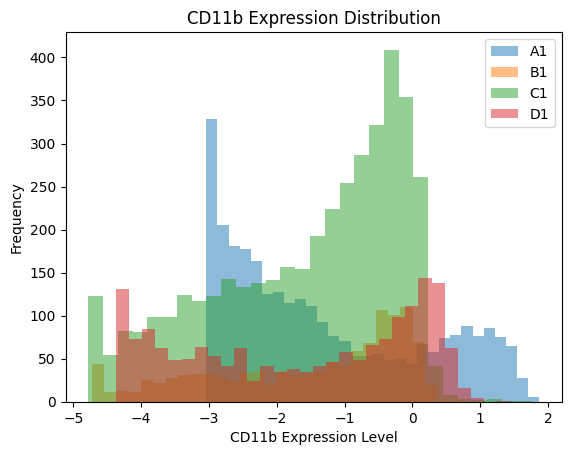

In [ ]:
import matplotlib.pyplot as plt

# Create histograms for CD11b expression in each specimen
for specimen in df["specimen_id"].unique():
    subset = df[df["specimen_id"] == specimen]
    plt.hist(subset["CD11b"], bins=30, alpha=0.5, label=specimen)

plt.xlabel("CD11b Expression Level")
plt.ylabel("Frequency")
plt.legend()
plt.title("CD11b Expression Distribution")
plt.show()


### iii. Image Pre-processing: Convert a selection of images from RGB to HED color space, focusing on the Hematoxylin channel (H) to highlight cellular nuclei. Provide visual examples following the hints in the notebook linked above.
A selection of tissue images was converted from RGB to HED color space, focusing on the Hematoxylin (H) channel. This channel highlights cell nuclei, which are important for analyzing protein expression. The images on the left show the original RGB tissue samples, while the right images display the Hematoxylin channel, where nuclei appear bright against a dark background. This helps capture key structures in the tissue that may be useful for predicting protein expression.

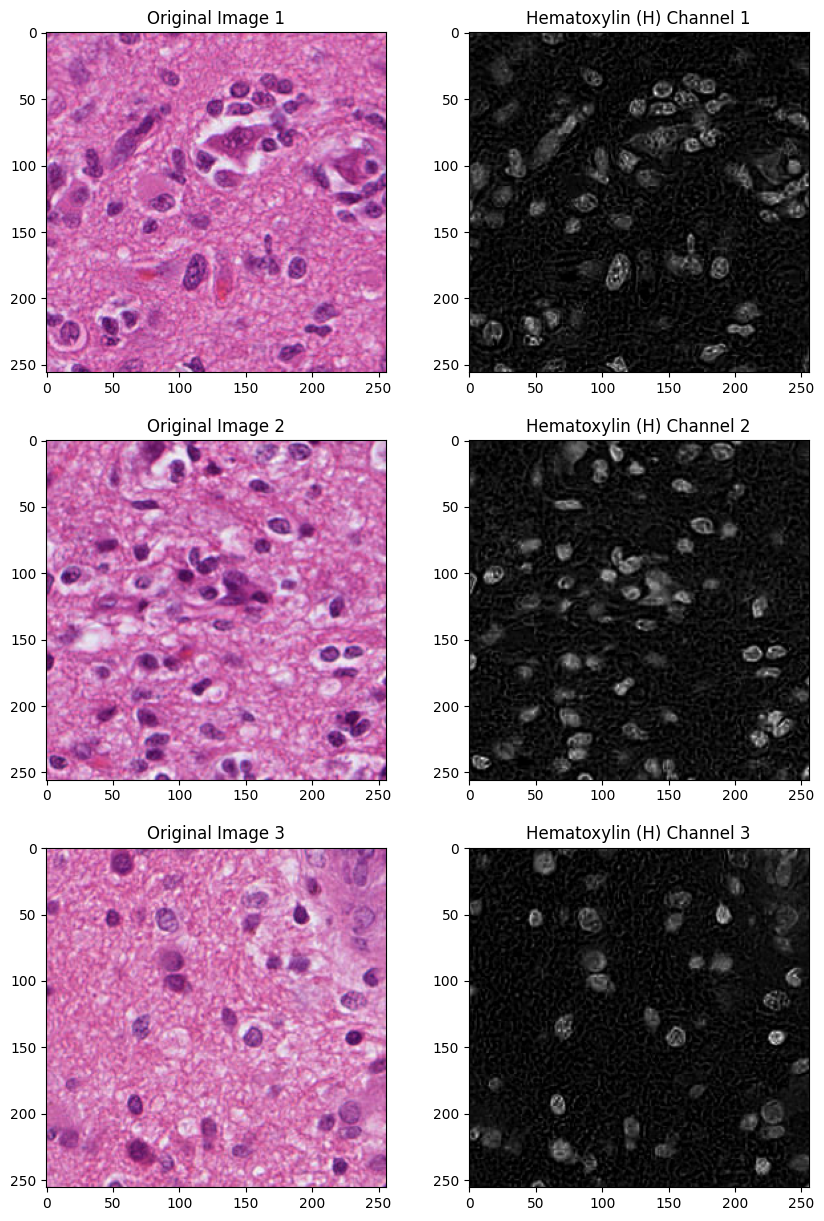

In [ ]:
import glob
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2hed

image_folder = "/content/patches_256/"
image_files = glob.glob(image_folder + "*.png")[:3]  # Select 3 images

fig, axes = plt.subplots(len(image_files), 2, figsize=(10, 5 * len(image_files)))

for i, image_path in enumerate(image_files):
    I = imread(image_path)  # Read image directly (without rgba2rgb)

    if I.shape[-1] == 4:  # Check if the image has an alpha channel (RGBA)
        I = I[:, :, :3]  # Remove the alpha channel to keep only RGB

    I_hed = rgb2hed(I)  # Convert to HED
    I_h = I_hed[:, :, 0]  # Extract Hematoxylin (H) channel

    axes[i, 0].imshow(I)
    axes[i, 0].set_title(f"Original Image {i+1}")
    axes[i, 1].imshow(I_h, cmap="gray")
    axes[i, 1].set_title(f"Hematoxylin (H) Channel {i+1}")

plt.show()


### iv. Calculate the average intensity of the H-channel for each image. Create a scatter plot comparing these averages against the expression levels of CD11b for each image. Assess the correlation between H-channel intensity and CD11b expression. Discuss the potential of H-channel average as a predictive feature for CD11b expression.
  The goal of this step is to determine whether Hematoxylin (H) channel intensity is correlated with CD11b protein expression levels.
  We need to process each image, convert it to HED color space, extract the Hematoxylin (H) channel, and calculate the average intensity.

#### a) Extract Mean H-Channel Intensity

The first step is extracting the mean H-channel intensity from each image. Since the images are in RGB format, they are converted into HED color space to isolate the Hematoxylin (H) channel, which highlights cell nuclei. The average intensity of the H-channel is then calculated for each image and added to the dataset.



In [ ]:
import numpy as np
from tqdm import tqdm
from skimage.io import imread
from skimage.color import rgb2hed

h_channel_avg = []

# Process each image
for img_id in tqdm(df.index):
    image_path = image_folder + img_id + ".png"

    try:
        I = imread(image_path)  # Read image

        # If the image has 4 channels (RGBA), remove the alpha channel
        if I.shape[-1] == 4:
            I = I[:, :, :3]  # Keep only RGB channels

        I_hed = rgb2hed(I)  # Convert to HED
        h_channel_avg.append(np.mean(I_hed[:, :, 0]))  # Mean of H-channel

    except FileNotFoundError:
        h_channel_avg.append(None)

df["H_Channel_Avg"] = h_channel_avg
df = df.dropna(subset=["H_Channel_Avg"])


100%|██████████| 9921/9921 [02:03<00:00, 80.35it/s]


#### b) Scatter Plot of H-Channel Intensity vs. CD11b
Once the H-channel intensity values are extracted, the second step is to visualize their relationship with CD11b expression using a scatter plot. The scatter plot below shows H-Channel intensity on the x-axis and CD11b expression levels on the y-axis.


The scatter plot indicates a wide spread of points without a clear trend, suggesting that H-Channel intensity may not be a strong predictor of CD11b expression. To confirm this observation, the Pearson correlation coefficient is computed.

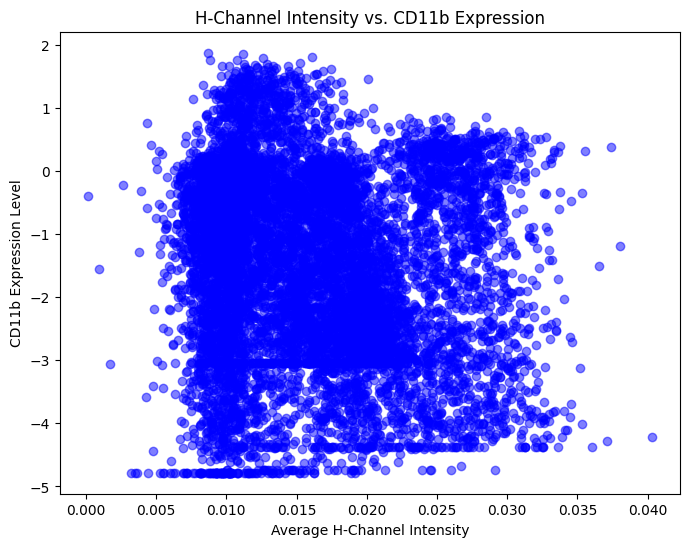

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df["H_Channel_Avg"], df["CD11b"], alpha=0.5, color="blue")
plt.xlabel("Average H-Channel Intensity")
plt.ylabel("CD11b Expression Level")
plt.title("H-Channel Intensity vs. CD11b Expression")
plt.show()


#### c) Compute Pearson Correlation
If the correlation value is close to +1 or -1, it indicates a strong linear relationship, meaning H-channel intensity could be a good predictor of CD11b expression. If the correlation value is close to 0, it suggests no strong relationship between the two variables, meaning other features may be needed for better prediction.

The Pearson correlation of -0.157 indicates a very weak negative relationship between the H-channel intensity and CD11b expression. This means that as H-channel intensity slightly increases, CD11b expression tends to decrease, but the relationship is very weak and likely not significant.

The results show that the Hematoxylin (H) channel intensity has little impact on CD11b expression levels. This suggests that other image-based features may be more relevant for prediction.


In [ ]:
from scipy.stats import pearsonr

# Compute Pearson correlation
correlation, _ = pearsonr(df["H_Channel_Avg"], df["CD11b"])

# Print result
print(f"Pearson Correlation: {correlation:.3f}")


Pearson Correlation: -0.157


### v. Calculate the average intensity of the blue channel for each image. Create a scatter plot comparing these averages against the expression levels of CD11b for each image. Assess the correlation between E-channel intensity and CD11b expression. Discuss the potential of E-channel average as a predictive feature for CD11b expression.

The goal of this step is to analyze the relationship between Blue-channel intensity from images and CD11b protein expression levels. This follows the same process as the H-channel analysis, but instead of using the Hematoxylin (H) channel, we extract the Blue channel from the RGB images.

#### a) Compute the Average Blue-Channel Intensity
Each image is read, and the mean intensity of the Blue channel is calculated. The results are stored in the dataset.

In [ ]:
import numpy as np
from tqdm import tqdm
from skimage.io import imread

blue_channel_avg = []

for img_id in tqdm(df.index):
    image_path = image_folder + img_id + ".png"

    try:
        I = imread(image_path)
        if I.shape[-1] == 4:
            I = I[:, :, :3]  # Remove alpha channel if present
        blue_channel_avg.append(np.mean(I[:, :, 2]))  # Extract Blue channel mean

    except FileNotFoundError:
        blue_channel_avg.append(None)

df["Blue_Channel_Avg"] = blue_channel_avg
df = df.dropna(subset=["Blue_Channel_Avg"])


100%|██████████| 9921/9921 [00:55<00:00, 177.89it/s]


#### b) Scatter Plot of Blue-Channel Intensity vs. CD11b
A scatter plot is used to visualize the relationship between Blue-Channel intensity and CD11b expression.

The scatter plot does not display a strong visible trend, suggesting that Blue-channel intensity might not be a strong predictor of CD11b expression. To confirm this observation, the Pearson correlation coefficient is computed.

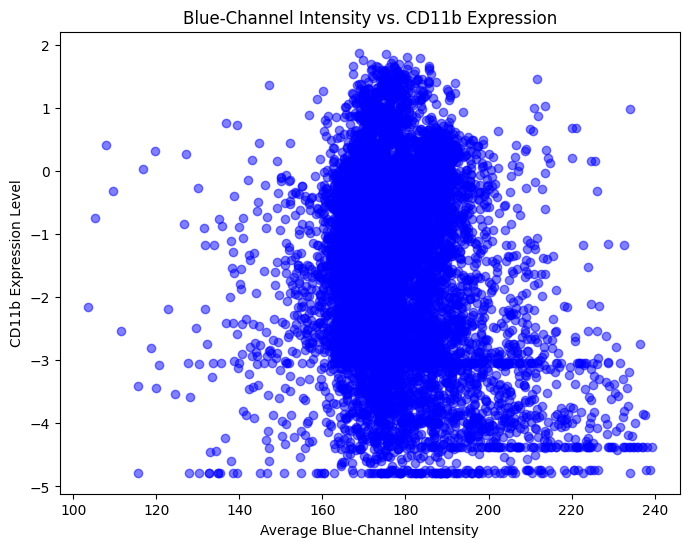

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df["Blue_Channel_Avg"], df["CD11b"], alpha=0.5, color="blue")
plt.xlabel("Average Blue-Channel Intensity")
plt.ylabel("CD11b Expression Level")
plt.title("Blue-Channel Intensity vs. CD11b Expression")
plt.show()


#### c) Compute Pearson Correlation

To measure the strength of the relationship, the Pearson correlation coefficient is calculated.

The computed Pearson correlation is -0.191, which indicates a weak negative correlation between Blue-Channel intensity and CD11b expression. A correlation close to 0 suggests that Blue-Channel intensity alone is not strongly predictive of CD11b levels.

The results show that Blue-channel intensity does not have a strong relationship with CD11b expression. Since both the H-channel (-0.157 correlation) and Blue-channel (-0.191 correlation) have weak relationships with CD11b, they might not be strong standalone features for prediction.

In [ ]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(df["Blue_Channel_Avg"], df["CD11b"])
print("Pearson Correlation:", correlation)


Pearson Correlation: -0.19148750151919738


### vi. Visualize (as a scatter plot) and quantify the degree of correlation or dependence between average H and average blue channel intensities across images. What are the implications of this?

This step examines whether Hematoxylin (H) channel intensity and Blue-channel intensity are correlated. If they are highly correlated, they provide similar information, and using both may be unnecessary. If they are weakly correlated, both could contribute unique information for prediction.

#### a) Scatter Plot of H-Channel vs. Blue-Channel
The scatter plot below visualizes the relationship between H-Channel intensity (x-axis) and Blue-Channel intensity (y-axis).

The plot shows a weak but noticeable positive trend, indicating some relationship between H-Channel and Blue-Channel intensities. To measure the strength of this relationship, the Pearson correlation coefficient was computed.

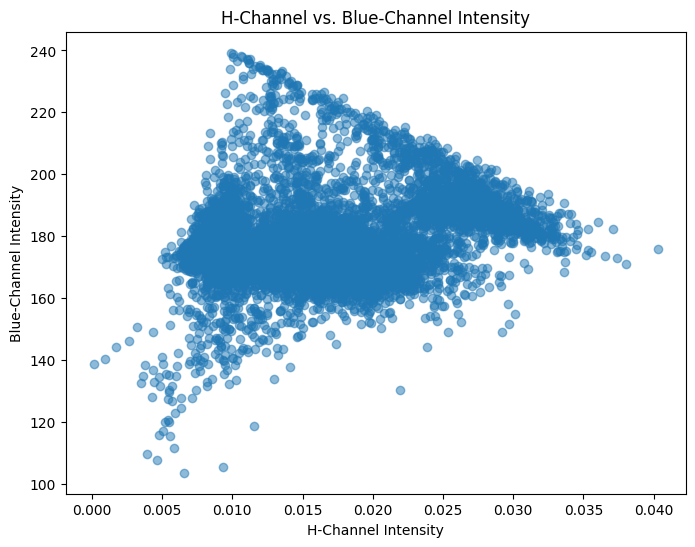

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df["H_Channel_Avg"], df["Blue_Channel_Avg"], alpha=0.5)
plt.xlabel("H-Channel Intensity")
plt.ylabel("Blue-Channel Intensity")
plt.title("H-Channel vs. Blue-Channel Intensity")
plt.show()


#### b) Compute Pearson Correlation

The computed Pearson correlation is 0.287, suggesting a weak positive correlation between the two channels. This means that as H-Channel intensity increases, Blue-Channel intensity tends to increase slightly as well. However, the correlation is not strong enough to conclude that both provide the same information.

Since the correlation between H-Channel and Blue-Channel is only 0.287, they are not strongly dependent on each other. This suggests that both features could be used together in a predictive model, as they might capture different aspects of the image data. If the correlation were much higher (e.g., above 0.8), one of the features could be removed to avoid redundancy.

In [ ]:
from scipy.stats import pearsonr

correlation, _ = pearsonr(df["H_Channel_Avg"], df["Blue_Channel_Avg"])
print("Pearson Correlation:", correlation)


Pearson Correlation: 0.28673770630440915


### vii. Is there association between protein expression levels of different proteins? If so, how can we quantify this association?
This step examines how different protein expression levels are correlated with each other. If two proteins are highly correlated, one might be redundant and could be removed during feature selection. If proteins show weak or no correlation, they likely provide independent information.

A correlation heatmap was generated to visualize these relationships. The correlation matrix was computed using Pearson correlation, and the top 10 strongest correlations were identified.

#### a) Compute Correlation Matrix and Visualize Heatmap
The correlation heatmap shows relationships between protein expression levels, where:

*   Red areas (closer to +1) indicate a strong positive correlation (proteins increase together).
*   Blue areas (closer to -1) indicate a strong negative correlation (one increases while the other decreases).
*   White/gray areas (near 0) indicate no strong correlation (independent proteins).



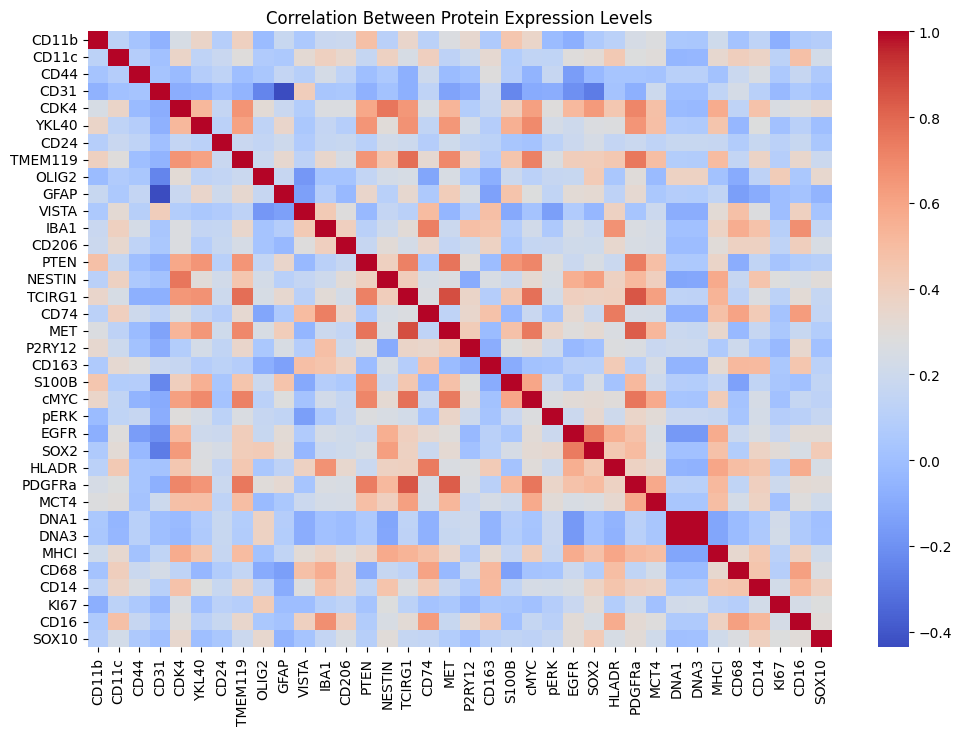

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only protein expression columns
protein_cols = ["CD11b", "CD11c", "CD44", "CD31", "CDK4", "YKL40", "CD24",
                "TMEM119", "OLIG2", "GFAP", "VISTA", "IBA1", "CD206", "PTEN",
                "NESTIN", "TCIRG1", "CD74", "MET", "P2RY12", "CD163", "S100B",
                "cMYC", "pERK", "EGFR", "SOX2", "HLADR", "PDGFRa", "MCT4", "DNA1",
                "DNA3", "MHCI", "CD68", "CD14", "KI67", "CD16", "SOX10"]

# Compute correlation matrix
corr_matrix = df[protein_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Between Protein Expression Levels")
plt.show()


#### b) Identify Strong Correlations


The results show the strongest correlations, with DNA1 and DNA3 having the highest correlation (0.999), followed by TCIRG1-MET (0.869) and TCIRG1-PDGFRa (0.848).
To improve feature selection for predictive modeling, removing redundant proteins or performing dimensionality reduction (e.g., PCA) may be beneficial.

The top 10 protein pairs with the highest correlations were extracted:


In [ ]:
# Get the upper triangle of the correlation matrix to avoid duplicate values
import numpy as np

mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
corr_pairs = corr_matrix.where(mask).stack().reset_index()
corr_pairs.columns = ["Protein 1", "Protein 2", "Correlation"]
corr_pairs = corr_pairs.sort_values(by="Correlation", ascending=False)

# Display the top 10 strongest correlations
print(corr_pairs.head(10))


    Protein 1 Protein 2  Correlation
602      DNA1      DNA3     0.999114
421    TCIRG1       MET     0.869006
430    TCIRG1    PDGFRa     0.848205
467       MET    PDGFRa     0.828382
231   TMEM119    TCIRG1     0.780194
425    TCIRG1      cMYC     0.771311
380      PTEN       MET     0.759903
143      CDK4    NESTIN     0.758211
529      cMYC    PDGFRa     0.754817
242   TMEM119    PDGFRa     0.748688


# Question 2

### i) The goal of this step is to extract informative features from images that can be used for predicting CD11b expression. You can use a variety of feature extraction methods, including statistical features, dimensionality reduction, or other image-based descriptors.

#### a) Extracting Statistical Features
One approach is to compute average and variance values from different image channels:

*   Hematoxylin (H), Eosin (E), DAB (D) channels from HED color space
*   Red (R), Green (G), Blue (B) channels from the original image



In [ ]:
import numpy as np
from skimage.io import imread
from skimage.color import rgb2hed

def extract_features(image_path):
    try:
        I = imread(image_path)
        if I.shape[-1] == 4:
            I = I[:, :, :3]  # Remove alpha channel if present

        # Convert to HED color space
        I_hed = rgb2hed(I)

        # Extract statistical features
        features = {
            "H_mean": np.mean(I_hed[:, :, 0]),
            "H_var": np.var(I_hed[:, :, 0]),
            "E_mean": np.mean(I_hed[:, :, 1]),
            "E_var": np.var(I_hed[:, :, 1]),
            "D_mean": np.mean(I_hed[:, :, 2]),
            "D_var": np.var(I_hed[:, :, 2]),
            "R_mean": np.mean(I[:, :, 0]),
            "R_var": np.var(I[:, :, 0]),
            "G_mean": np.mean(I[:, :, 1]),
            "G_var": np.var(I[:, :, 1]),
            "B_mean": np.mean(I[:, :, 2]),
            "B_var": np.var(I[:, :, 2])
        }
        return features
    except FileNotFoundError:
        return None


Once this function is defined, we extract features for all images.

In [ ]:
import pandas as pd
from tqdm import tqdm

feature_list = []

for img_id in tqdm(df.index):
    image_path = image_folder + img_id + ".png"
    features = extract_features(image_path)
    if features:
        features["image_id"] = img_id
        feature_list.append(features)


# Convert extracted features into a DataFrame
feature_df = pd.DataFrame(feature_list).set_index("image_id")

# Remove existing columns in df before merging to avoid conflicts
df = df.drop(columns=feature_df.columns, errors="ignore")

# Merge extracted features with the dataset
df = df.join(feature_df, on="image_id")

# Check if features are correctly merged
print("Extracted Features (first 5 rows):")
print(df.head())


100%|██████████| 9921/9921 [02:30<00:00, 65.96it/s]


Extracted Features (first 5 rows):
          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                                        
A1_0x40          247.700528 -2.895476 -1.445686 -1.875972 -3.456108  0.461409   
A1_0x42          184.389514 -2.895476 -1.198798 -2.070174 -3.456108 -0.002521   
A1_0x44          109.598681 -2.895476 -1.631987 -1.920100 -3.456108  0.549366   
A1_0x46           42.981582 -2.895476 -1.922144 -1.941790 -3.456108  0.639180   
A1_0x48         

#### c) Apply Principal Component Analysis (PCA)
We apply PCA to reduce the dimensionality of the original image data.

In [ ]:
from sklearn.decomposition import PCA

# Flatten images into feature vectors
image_vectors = []
valid_ids = []

for img_id in tqdm(df.index):
    image_path = image_folder + img_id + ".png"
    try:
        I = imread(image_path)
        if I.shape[-1] == 4:
            I = I[:, :, :3]
        I_resized = I.reshape(-1, 3)  # Flatten image pixels
        image_vectors.append(I_resized.mean(axis=0))  # Mean pixel values
        valid_ids.append(img_id)
    except FileNotFoundError:
        print(f"File not found: {image_path}")
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# Convert to DataFrame
pca_data = pd.DataFrame(image_vectors, columns=["PCA_R", "PCA_G", "PCA_B"], index=valid_ids)

# Drop existing PCA-related columns before merging to avoid conflicts
df = df.drop(columns=["PCA_R", "PCA_G", "PCA_B"], errors="ignore")

# Merge PCA data with the dataset
df = df.join(pca_data)

# Apply PCA with correct number of components
pca = PCA(n_components=3)  # Reduce to 3 principal components
principal_components = pca.fit_transform(df[["PCA_R", "PCA_G", "PCA_B"]].dropna())

# Convert PCA results into DataFrame
pca_df = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(3)], index=df.index)

# Drop raw PCA_R, PCA_G, PCA_B before merging
df = df.drop(columns=["PCA_R", "PCA_G", "PCA_B"], errors="ignore")

# Merge PCA features with dataset
df = df.join(pca_df)

# Check PCA results
print("PCA Components (first 5 rows):")
print(df.head())


100%|██████████| 9921/9921 [01:15<00:00, 130.75it/s]


PCA Components (first 5 rows):
          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                                        
A1_0x40          247.700528 -2.895476 -1.445686 -1.875972 -3.456108  0.461409   
A1_0x42          184.389514 -2.895476 -1.198798 -2.070174 -3.456108 -0.002521   
A1_0x44          109.598681 -2.895476 -1.631987 -1.920100 -3.456108  0.549366   
A1_0x46           42.981582 -2.895476 -1.922144 -1.941790 -3.456108  0.639180   
A1_0x48          958

#### c) Select the Most Relevant Features
Now that we have extracted statistical features and PCA components, we select only the most relevant features for regression modeling.

In [ ]:
selected_features = [
    "H_mean", "H_var", "E_mean", "E_var", "D_mean", "D_var",  # HED features
    "R_mean", "R_var", "G_mean", "G_var", "B_mean", "B_var",  # RGB features
    "PC1", "PC2", "PC3"  # PCA components
]

# Filter dataset to only keep selected features and target variable
df_selected = df[selected_features + ["CD11b"]]

# Check final dataset before moving to regression modeling
print("Final dataset (first 5 rows):")
print(df_selected.head())


Final dataset (first 5 rows):
            H_mean     H_var    E_mean     E_var    D_mean     D_var  \
image_id                                                               
A1_0x40   0.013534  0.000378  0.014727  0.000447  0.013064  0.000194   
A1_0x42   0.015797  0.000390  0.030326  0.000445  0.022745  0.000192   
A1_0x44   0.015550  0.000353  0.035165  0.000353  0.024612  0.000126   
A1_0x46   0.017684  0.000379  0.041112  0.000352  0.027499  0.000118   
A1_0x48   0.017878  0.000430  0.043775  0.000351  0.029226  0.000126   

              R_mean        R_var      G_mean        G_var      B_mean  \
image_id                                                                 
A1_0x40   216.465088  1036.697084  181.384338  3085.239949  210.042633   
A1_0x42   202.116943  1238.317440  134.284088  2592.018446  183.336899   
A1_0x44   199.589981  1113.058218  122.246490  1905.673801  177.482666   
A1_0x46   192.781448  1160.145549  108.201324  1621.589443  168.975937   
A1_0x48   191.433960 

### ii) Now that we have extracted and selected features, we will train regression models to predict CD11b expression levels. The steps involved are:


1.   Prepare the dataset for training and testing.

2.   Train regression models, including:


 *   Ordinary Least Squares (OLS) Regression
 *   Random Forest Regression
 *    Support Vector Regression (SVR)




3.   Evaluate model performance using:


*   Root Mean Squared Error (RMSE)
*   Pearson Correlation Coefficient
*   Spearman Correlation Coefficient
*   R² Score

4.  Visualize predictions with scatter plots.


#### 1. Prepare the dataset for training and testing.


In [ ]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = df_selected.drop(columns=["CD11b"])
y = df_selected["CD11b"]

# Ensure training data comes from B1, C1, D1, and test data from A1
X_train = X[df["specimen_id"] != "A1"]
y_train = y[df["specimen_id"] != "A1"]
X_test = X[df["specimen_id"] == "A1"]
y_test = y[df["specimen_id"] == "A1"]

print("Training set size:", X_train.shape, " | Testing set size:", X_test.shape)


Training set size: (7027, 15)  | Testing set size: (2894, 15)


#### 2. **Train** Regression Models

###### Model 1: Ordinary Least Squares (OLS) Regression


In [ ]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

# Predict on test data
y_pred_ols = ols_model.predict(X_test)


#####  Model 2: Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)


##### Model 3: Support Vector Regression (SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_model = SVR(kernel="rbf")
svr_model.fit(X_train_scaled, y_train)
y_pred_svr = svr_model.predict(X_test_scaled)


#### 3. Evaluate Model Performance
We calculate RMSE, Pearson correlation, Spearman correlation, and R² Score for each model.

The best metric for this prediction problem is RMSE because it measures how far the predictions are from the actual values, with lower RMSE meaning better accuracy. R² Score shows how well the model explains the variability in CD11b expression, with negative values meaning poor performance. Pearson Correlation checks if predictions follow actual trends, while Spearman Correlation looks at ranking similarity. RMSE is the most important since it directly measures prediction error, while correlations and R² help understand how well the model captures patterns.

These results suggest that:

* OLS regression performs poorly, likely due to multicollinearity or non-linearity in the data.
* Random Forest performs slightly better, but still does not generalize well.
* SVR has the lowest RMSE but an almost zero correlation, indicating overfitting or weak feature relevance.
Since all models have negative R² scores, they fail to capture patterns in the data effectively.



In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)  # Compute RMSE manually
    r2 = r2_score(y_true, y_pred)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    spearman_corr, _ = spearmanr(y_true, y_pred)

    print(f" {model_name} Performance:")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}")
    print(f"  - Pearson Correlation: {pearson_corr:.4f}")
    print(f"  - Spearman Correlation: {spearman_corr:.4f}")
    print("-------------------------------------------------")

# Evaluate all models
evaluate_model(y_test, y_pred_ols, "Ordinary Least Squares (OLS) Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regression")
evaluate_model(y_test, y_pred_svr, "Support Vector Regression (SVR)")


 Ordinary Least Squares (OLS) Regression Performance:
  - RMSE: 1.7453
  - R² Score: -0.4768
  - Pearson Correlation: 0.3481
  - Spearman Correlation: 0.3464
-------------------------------------------------
 Random Forest Regression Performance:
  - RMSE: 1.5988
  - R² Score: -0.2393
  - Pearson Correlation: 0.4113
  - Spearman Correlation: 0.3980
-------------------------------------------------
 Support Vector Regression (SVR) Performance:
  - RMSE: 1.4605
  - R² Score: -0.0342
  - Pearson Correlation: 0.5058
  - Spearman Correlation: 0.5197
-------------------------------------------------


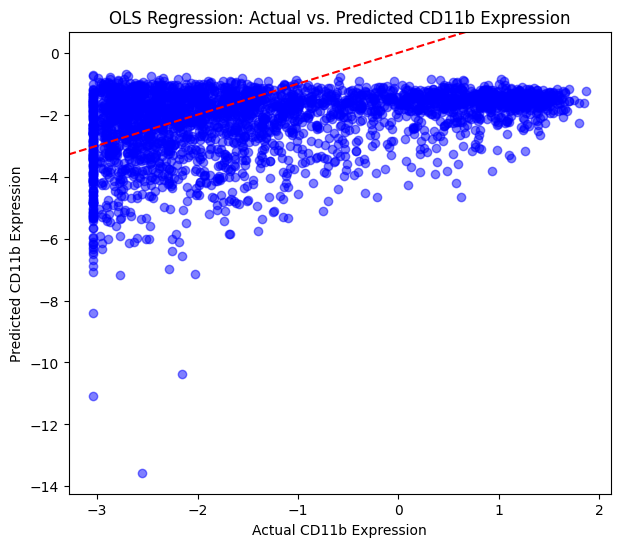

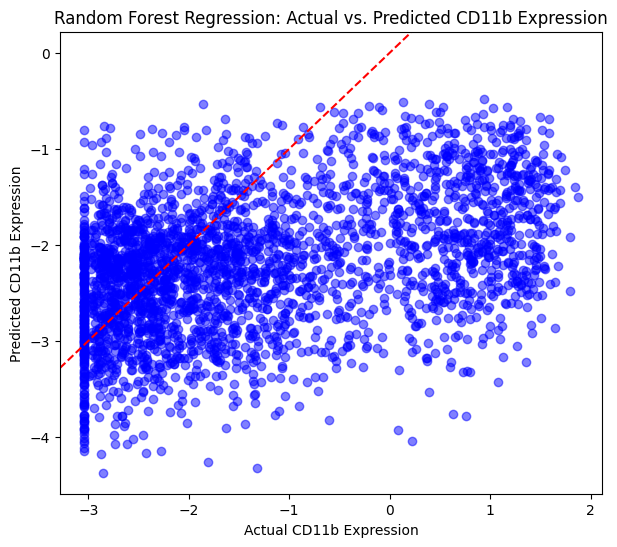

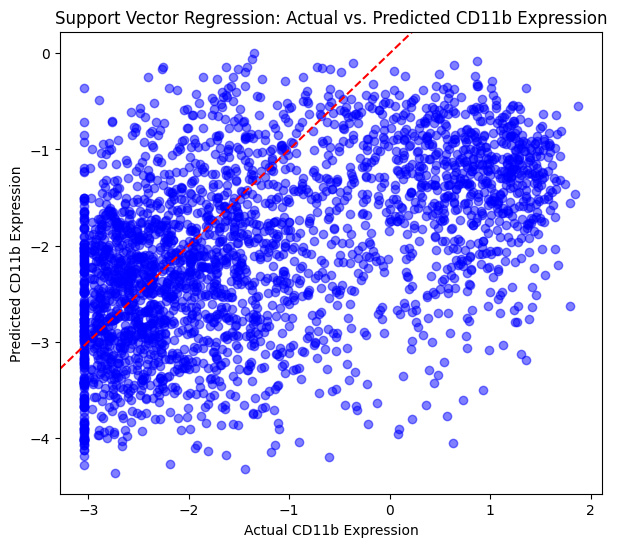

In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(7, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, color="blue")
    plt.xlabel("Actual CD11b Expression")
    plt.ylabel("Predicted CD11b Expression")
    plt.title(f"{model_name}: Actual vs. Predicted CD11b Expression")
    plt.axline((0, 0), slope=1, color="red", linestyle="--")  # Ideal line
    plt.show()

plot_predictions(y_test, y_pred_ols, "OLS Regression")
plot_predictions(y_test, y_pred_rf, "Random Forest Regression")
plot_predictions(y_test, y_pred_svr, "Support Vector Regression")
